<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Density_estimation_using_Real_NVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real NVP를 사용한 밀도 추정
- 내용 출처: https://keras.io/examples/generative/real_nvp/
- 목표: 샘플링하기 쉽고 밀도를 추정하기 쉬운 간단한 분포를 데이터에서 학습된 더 복잡한 분포로 매핑하는 것
- nomalizing flow 모델 -> "변수 변경" 공식을 사용하여 최대 가능도 원칙을 통해 학습

## 01. Import library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

## 02. 데이터 불러오기

In [2]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

## 03. Affine coupling layer

In [3]:
output_dim = 256
reg = 0.01

In [4]:
def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

## 04. Real NVP

In [5]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

## 05. 모델 훈련

In [6]:
# 모델 구축
model = RealNVP(num_coupling_layers=6)

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

# 모델 훈련
history = model.fit(
    normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2
)

Epoch 1/300
10/10 - 10s - loss: 2.7034 - val_loss: 2.5762 - 10s/epoch - 1s/step
Epoch 2/300
10/10 - 1s - loss: 2.6142 - val_loss: 2.5362 - 1s/epoch - 117ms/step
Epoch 3/300
10/10 - 1s - loss: 2.5673 - val_loss: 2.4916 - 1s/epoch - 109ms/step
Epoch 4/300
10/10 - 1s - loss: 2.5192 - val_loss: 2.4665 - 1s/epoch - 115ms/step
Epoch 5/300
10/10 - 1s - loss: 2.4820 - val_loss: 2.4508 - 1s/epoch - 108ms/step
Epoch 6/300
10/10 - 1s - loss: 2.4500 - val_loss: 2.4199 - 1s/epoch - 107ms/step
Epoch 7/300
10/10 - 1s - loss: 2.4241 - val_loss: 2.4033 - 1s/epoch - 117ms/step
Epoch 8/300
10/10 - 1s - loss: 2.3903 - val_loss: 2.3808 - 1s/epoch - 117ms/step
Epoch 9/300
10/10 - 1s - loss: 2.3633 - val_loss: 2.3604 - 1s/epoch - 113ms/step
Epoch 10/300
10/10 - 1s - loss: 2.3350 - val_loss: 2.3273 - 1s/epoch - 113ms/step
Epoch 11/300
10/10 - 1s - loss: 2.3181 - val_loss: 2.3087 - 1s/epoch - 107ms/step
Epoch 12/300
10/10 - 1s - loss: 2.2912 - val_loss: 2.2786 - 1s/epoch - 106ms/step
Epoch 13/300
10/10 - 1s - 

## 06. 성능 평가

(-2.0, 2.0)

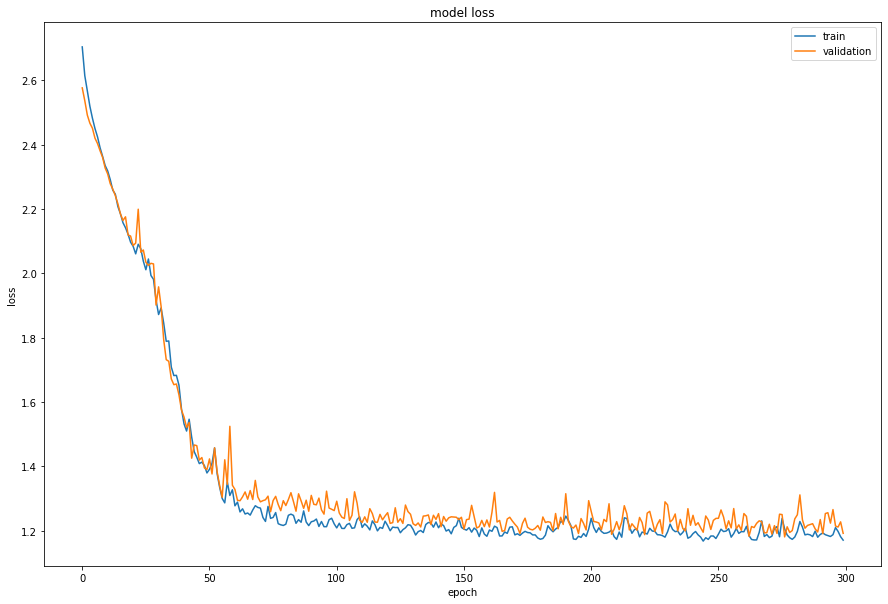

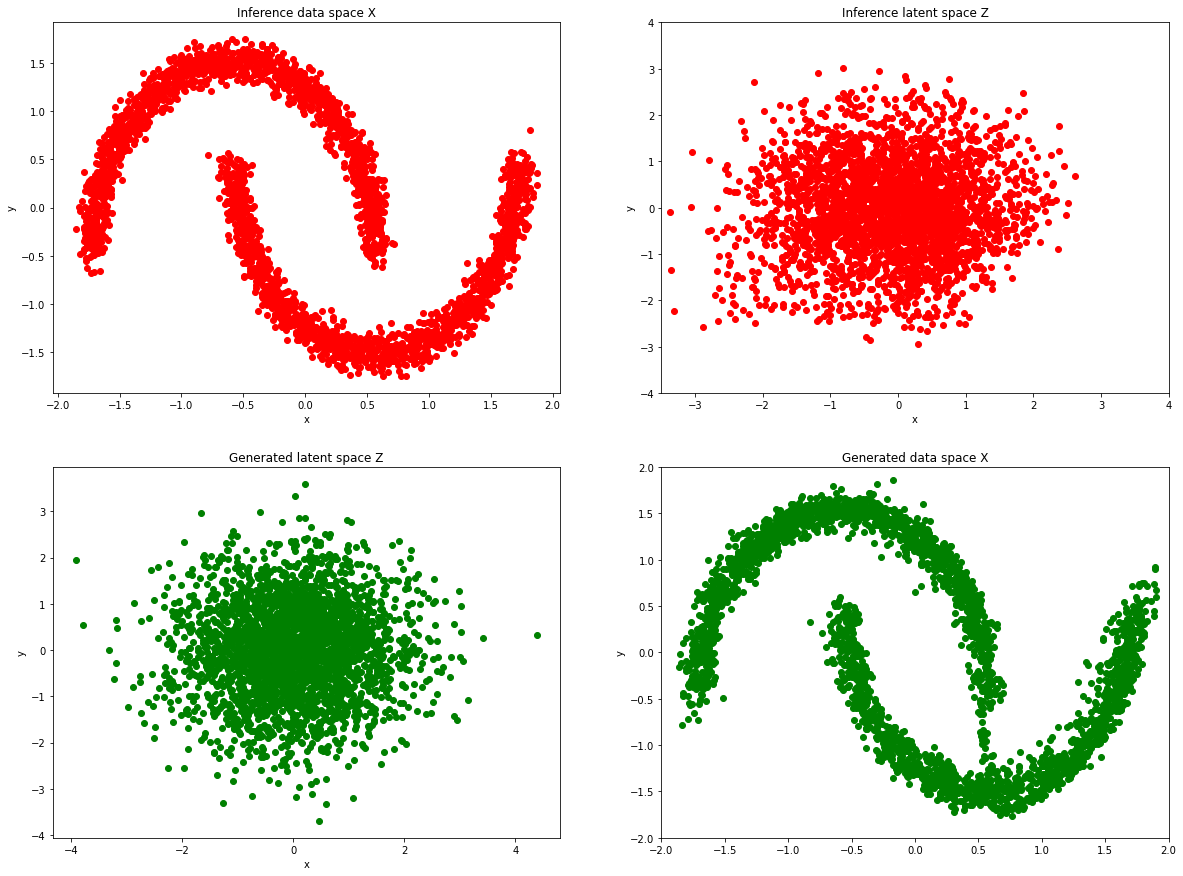

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

z, _ = model(normalized_data)

samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])